In [1]:
import os
import pandas as pd
import tensorflow as tf

In [2]:
def normalize_series(data, min, max):
    data-=min
    data/=max
    return data

def windowed_dataset(series, batch_size, n_past=24, n_future=4, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past+n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past+n_future))
    ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-n_future], w[-n_future:, :1]))
    ds = ds.batch(batch_size).prefetch(shift)
    return ds

In [3]:
# Retrieve dataset
lettuce_df = pd.read_csv(os.path.join('./dataset/2/lettuce_dataset.csv'), sep=',', encoding='ISO-8859-1')
lettuce_df.head()


,Plant_ID,Date,Temperature (°C),Humidity (%),TDS Value (ppm),pH Level,Growth Days
0,1,8/3/2023,33.4,53,582,6.4,1
1,1,8/4/2023,33.5,53,451,6.1,2
2,1,8/5/2023,33.4,59,678,6.4,3
3,1,8/6/2023,33.4,68,420,6.4,4
4,1,8/7/2023,33.4,74,637,6.5,5


In [4]:
lettuce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Plant_ID          3169 non-null   int64  
 1   Date              3169 non-null   object 
 2   Temperature (°C)  3169 non-null   float64
 3   Humidity (%)      3169 non-null   int64  
 4   TDS Value (ppm)   3169 non-null   int64  
 5   pH Level          3169 non-null   float64
 6   Growth Days       3169 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 173.4+ KB


In [5]:
lettuce_df.describe()

,Plant_ID,Temperature (°C),Humidity (%),TDS Value (ppm),pH Level,Growth Days
count,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000
mean,35.441780,28.142222,64.873462,598.045440,6.399211,23.140107
std,20.243433,4.670521,8.988985,115.713047,0.234418,13.075415
min,1.000000,18.000000,50.000000,400.000000,6.000000,1.000000
25%,18.000000,23.600000,57.000000,498.000000,6.200000,12.000000
50%,35.000000,30.200000,65.000000,593.000000,6.400000,23.000000
75%,53.000000,31.500000,73.000000,699.000000,6.600000,34.000000
max,70.000000,33.500000,80.000000,800.000000,6.800000,48.000000


In [6]:
# Check for missing and duplicate values
print('Missing values: ', lettuce_df.isnull().any().sum())
print('Duplicate values: ', lettuce_df.duplicated().sum())

Missing values:  0
Duplicate values:  0


In [7]:
lettuce_df.columns

Index(['Plant_ID', 'Date', 'Temperature (°C)', 'Humidity (%)',
       'TDS Value (ppm)', 'pH Level', 'Growth Days'],
      dtype='object')

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

%matplotlib inline
warnings.filterwarnings('ignore')

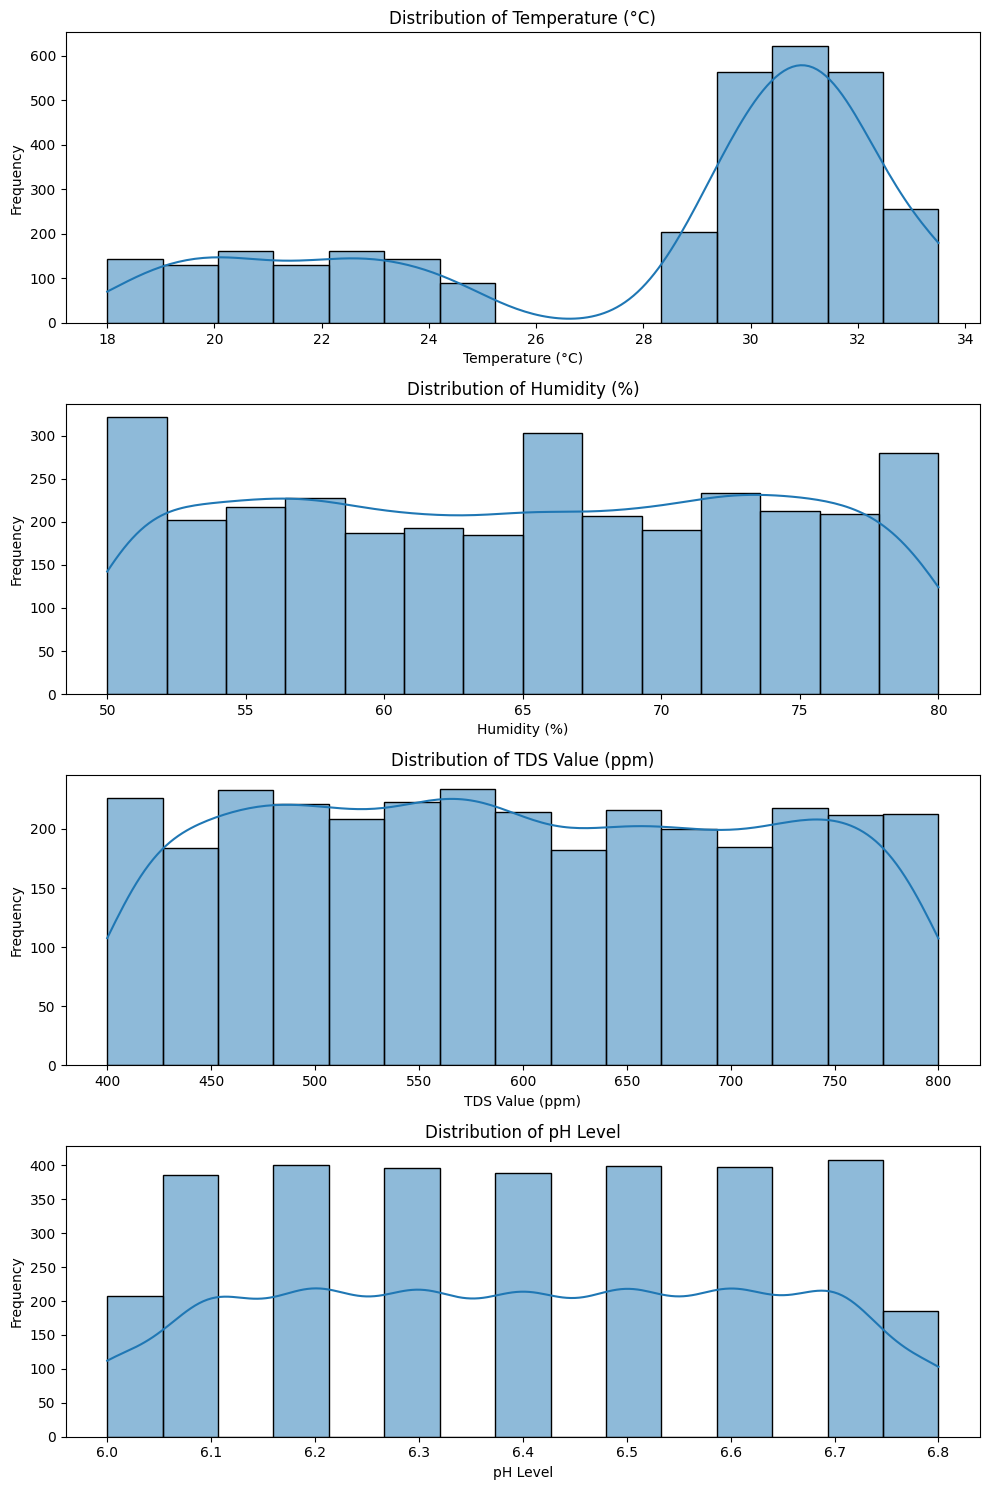

In [9]:
# Check for the distribution of the features
feature_to_plot = ['Temperature (°C)', 'Humidity (%)',
       'TDS Value (ppm)', 'pH Level']

fig, axs = plt.subplots(len(feature_to_plot), figsize=(10, 15))

# plot each feature's distribution
for i, feature in enumerate(feature_to_plot):
    sns.histplot(lettuce_df[feature], ax=axs[i], kde=True)
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

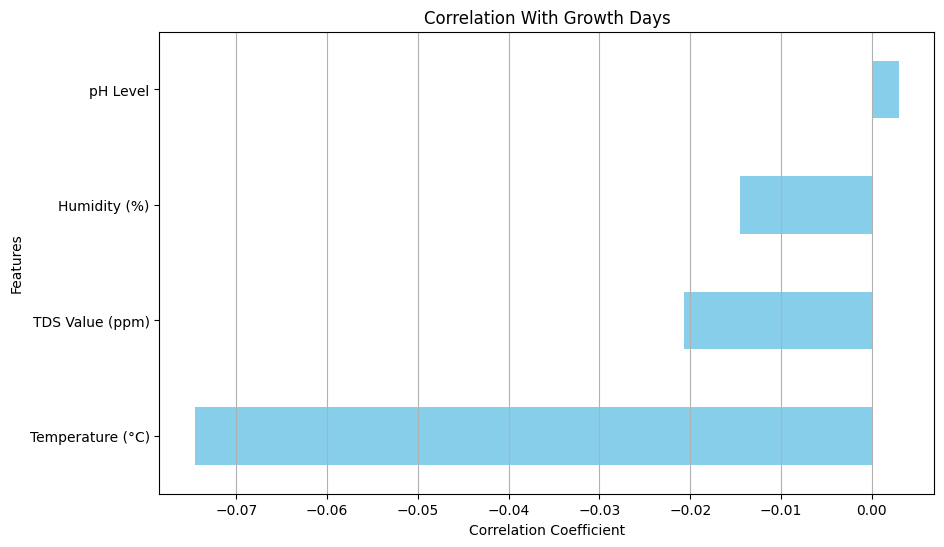

Correlation Values: 
 Temperature (°C)   -0.074601
Humidity (%)       -0.014481
TDS Value (ppm)    -0.020633
pH Level            0.003023
Name: Growth Days, dtype: float64


In [10]:
# Check for the correlation of features with the target variable 'Growth Days'

correlations = lettuce_df[feature_to_plot + ['Growth Days']].corr()['Growth Days'].drop('Growth Days')

plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation With Growth Days')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

print('Correlation Values: \n', correlations)

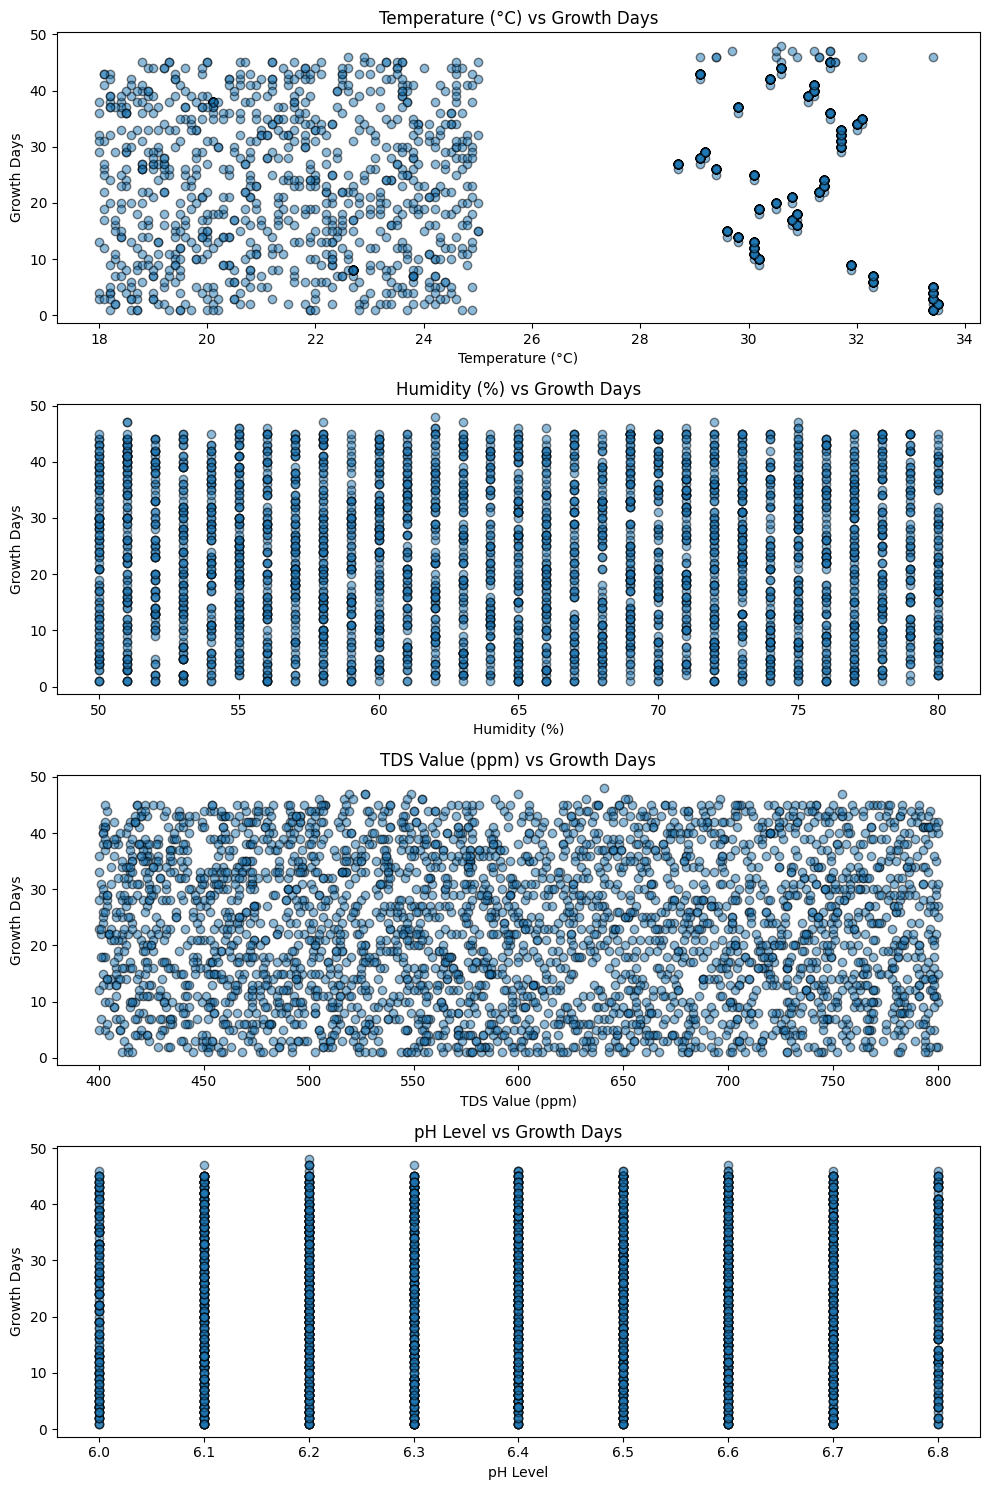

In [11]:
# Create a scatter plot for the features against 'Growth Days'
fig, axs = plt.subplots(len(feature_to_plot), figsize=(10, 15))

for i, feature in enumerate(feature_to_plot):
    axs[i].scatter(lettuce_df[feature], lettuce_df['Growth Days'], alpha=0.5, edgecolor='k')
    axs[i].set_title(f'{feature} vs Growth Days')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Growth Days')
    
    
plt.tight_layout()
plt.show()

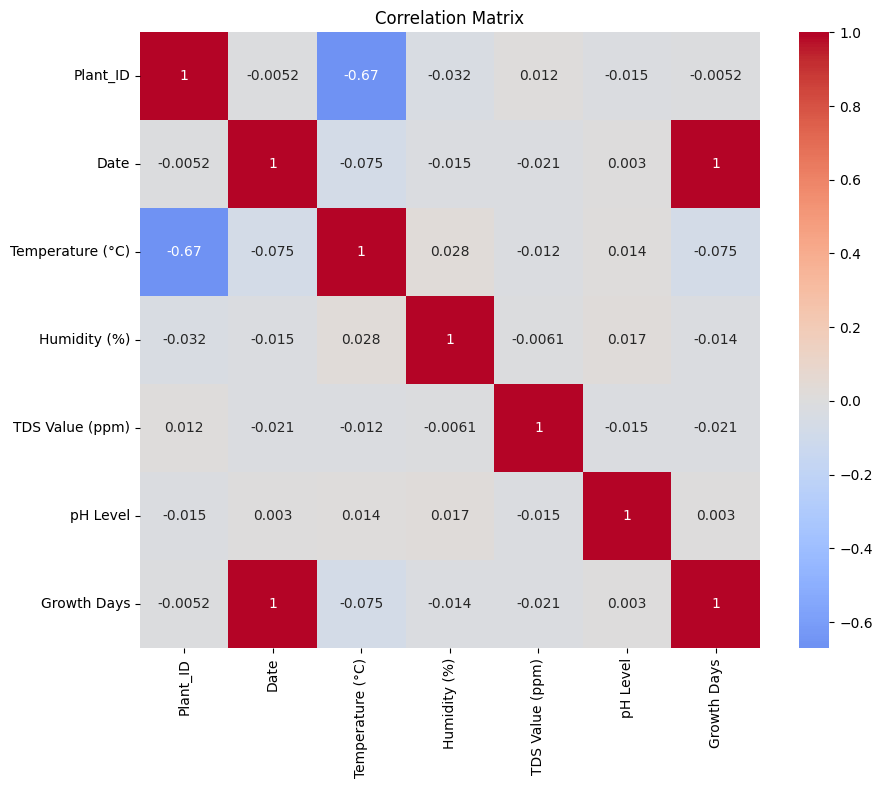

In [12]:
lettuce_df['Date'] = pd.to_datetime(lettuce_df['Date']).map(pd.Timestamp.toordinal)



# Create correlation matrix
correlation_matrix = lettuce_df.corr()


# Visualize the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [13]:
lettuce_df.columns

Index(['Plant_ID', 'Date', 'Temperature (°C)', 'Humidity (%)',
       'TDS Value (ppm)', 'pH Level', 'Growth Days'],
      dtype='object')

In [14]:

# Delete column date, plant_id
lettuce_df = lettuce_df.drop(columns=['Plant_ID', 'Date'])
# lettuce_df = lettuce_df.drop(columns=['Plant_ID'])

# Number of features in dataset
N_FEATURES = lettuce_df.shape[1]

print(lettuce_df.head())
print(F'n features: {N_FEATURES}')


   Temperature (°C)  Humidity (%)  TDS Value (ppm)  pH Level  Growth Days
0              33.4            53              582       6.4            1
1              33.5            53              451       6.1            2
2              33.4            59              678       6.4            3
3              33.4            68              420       6.4            4
4              33.4            74              637       6.5            5
n features: 5


In [15]:
# Normalize data
data = lettuce_df.values
split_time = int(len(data)*0.8)
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

x_train = data[:split_time]
print(f'Train: {len(x_train)}')
x_valid = data[split_time:]
print(f'Test: {len(x_valid)}')


Train: 2535
Test: 634


In [16]:
# DO NOT CHANGE THIS
BATCH_SIZE = 32
N_PAST = 24  # Number of past time steps based on which future observations should be predicted
N_FUTURE = 24  # Number of future time steps which are to be predicted.
SHIFT = 1  # By how many positions the window slides to create a new window of observations.

# Code to create windowed train and validation datasets.
# Complete the code in windowed_dataset.
# YOUR CODE HERE
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE, n_past=N_PAST, n_future=N_FUTURE, shift=SHIFT)
# YOUR CODE HERE
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE, n_past=N_PAST, n_future=N_FUTURE, shift=SHIFT)

model = tf.keras.models.Sequential([
    # tf.keras.layers.LSTM(64, 'relu', return_sequences=True, input_shape=[N_PAST, N_FEATURES]),
    tf.keras.layers.Dense(64, input_shape=(N_PAST, N_FEATURES)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1, 'linear'),
])


class StopWhenReachDesireMAE(tf.keras.callbacks.Callback):
    def __init__(self, monitor='mae', monitor2='val_mae', target=0.14):
        super(StopWhenReachDesireMAE, self).__init__()
        self.monitor = monitor
        self.monitor2 = monitor2
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        current2 = logs.get(self.monitor2)
        if current is not None and current2 is not None:
            if current < self.target and current2 < self.target:
                print(
                    f'\nEpoch {epoch + 1}: {self.monitor} and {self.monitor2} have reached {self.target}. Stopping training.')
                self.model.stop_training = True

stop_callback = StopWhenReachDesireMAE('mae', 'val_mae', 0.00001)

# Code to train and compile the model
# YOUR CODE HERE
model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history = model.fit(
    train_set,
    epochs=150,
    validation_data=valid_set,
    callbacks=[stop_callback]
)




Epoch 1/150


78/78 [==============================] - 1s 7ms/step - loss: 0.0110 - mae: 0.0777 - val_loss: 0.0130 - val_mae: 0.0965
Epoch 2/150
78/78 [==============================] - 0s 4ms/step - loss: 0.0083 - mae: 0.0659 - val_loss: 0.0151 - val_mae: 0.1053
Epoch 3/150
78/78 [==============================] - 0s 4ms/step - loss: 0.0083 - mae: 0.0662 - val_loss: 0.0153 - val_mae: 0.1058
Epoch 4/150
78/78 [==============================] - 0s 4ms/step - loss: 0.0083 - mae: 0.0658 - val_loss: 0.0125 - val_mae: 0.0939
Epoch 5/150
78/78 [==============================] - 0s 4ms/step - loss: 0.0084 - mae: 0.0663 - val_loss: 0.0141 - val_mae: 0.1007
Epoch 6/150
78/78 [==============================] - 0s 4ms/step - loss: 0.0083 - mae: 0.0663 - val_loss: 0.0132 - val_mae: 0.0970
Epoch 7/150
78/78 [==============================] - 0s 4ms/step - loss: 0.0083 - mae: 0.0660 - val_loss: 0.0126 - val_mae: 0.0944
Epoch 8/150
78/78 [==============================] - 0s 4ms/step - loss: 0.0083

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 64)            384       
                                                                 
 dense_1 (Dense)             (None, 24, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 2497 (9.75 KB)
Trainable params: 2497 (9.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


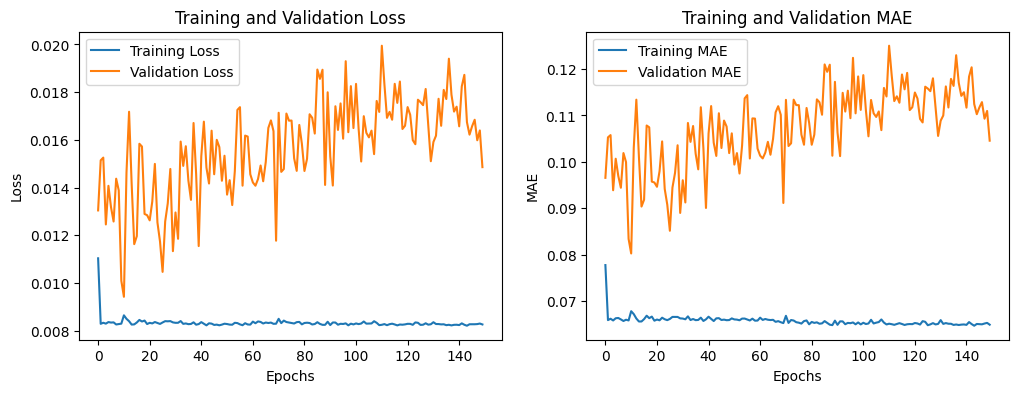

In [18]:
# Plotting training & validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [19]:
print("Dimensi x_train:", x_train.shape)
# print("Dimensi input_data:", input_data.shape)


Dimensi x_train: (2535, 5)


In [26]:
# Generate 4 random input values
import numpy as np

# np.random.seed(0)
# temp = np.random.uniform(20, 30, size=(4, N_PAST))  # Temperature (°C)
# humid = np.random.uniform(40, 60, size=(4, N_PAST))  # Humidity (%)
# tds = np.random.uniform(100, 200, size=(4, N_PAST))  # TDS Value (ppm)
# ph = np.random.uniform(6, 8, size=(4, N_PAST))  # pH Level
# gr = np.random.uniform(1,45, size=(4,N_PAST))

temp = 27
humid = 55
tds = 150
ph = 7
gr = 45

# Combine the features into one array
inputs = np.array([[temp, humid, tds, ph, gr]]) 
inputs = np.tile(inputs, (24, 1))  # Mereplikasi masukan untuk 24 langkah waktu sebelumnya
# Scale the inputs if necessary (you need to use the same scaler you used during training)
# Example:
# scaled_inputs = scaler.transform(inputs)

# Make predictions
predictions = model.predict(inputs.reshape(1, 24, 5))  # Menyesuaikan bentuk masukan untuk model
# Print the predictions
print(f" input testing {temp} {humid} {tds} {ph} { gr}")
print("Predictions:")
print(predictions)


1/1 [==============================] - 0s 20ms/step
 input testing 27 55 150 7 45
Predictions:
[[[13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]
  [13.792867]]]


In [21]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/mlp3'

tf.saved_model.save(model,export_dir=export_dir)

INFO:tensorflow:Assets written to: saved_model/mlp3\assets


INFO:tensorflow:Assets written to: saved_model/mlp3\assets


In [22]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [23]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

In [24]:
import pathlib

tflite_model_file = pathlib.Path('./saved_model/mlp3_noFeaEng(noDate).tflite')
tflite_model_file.write_bytes(tflite_model)


model.save("./saved_model/h5File/mlp3_noFeaEng(noDate).h5")


# #TANPA DATE
# import pathlib

# tflite_model_file = pathlib.Path('./saved_model/model.tflite')
# tflite_model_file.write_bytes(tflite_model)